*This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Ben Sattelberg and Asa Ben-Hur.
The content is availabe [on GitHub](https://github.com/asabenhur/CS345).*

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<a href="https://colab.research.google.com/github//asabenhur/CS345/blob/master/fall22/notebooks/module07_02_neural_networks_keras.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Neural Networks with Keras

In [1]:
import numpy as np
#import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
tf.executing_eagerly()

True

### Plotting functionality for later

In [2]:
from mpl_toolkits.mplot3d import Axes3D

def plot_XOR_network(network, two_outputs=False, transform=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax2 = fig.add_subplot(122, projection='3d')

    delta = 0.01
    xmin=-0.1;xmax=1.1;ymin=-0.1;ymax=1.1
    xs = np.arange(xmin, xmax, delta)
    ys = np.arange(ymin, ymax, delta)
    x_grid, y_grid = np.meshgrid(xs, ys)

    xs = x_grid.reshape(-1)
    ys = y_grid.reshape(-1)
    x = np.vstack((xs, ys))
    Z = network.predict(x.T)
    if two_outputs and not transform:
        Z = Z[:, 1] - Z[:, 0]
    elif two_outputs and transform:
        Z = transform(Z[:, 1]) - transform(Z[:, 0])
    Z = Z.reshape(x_grid.shape)

    if two_outputs:
        im = ax.imshow(Z, origin='lower',
                    cmap=plt.cm.bwr, extent=(xmin,xmax,ymin,ymax), vmin=-1, vmax=1)
    else:
        im = ax.imshow(Z, origin='lower',
                    cmap=plt.cm.bwr, extent=(xmin,xmax,ymin,ymax), vmin=0, vmax=1)

    X = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
    y = np.array([1, 0, 0, 1])

    plt.style.use('default')
    ax.scatter(X[:,0], X[:,1], c=y, s=50, cmap='bwr', edgecolors='w');
    ax.plot([], [], 'or', label='1')
    ax.plot([], [], 'ob', label='0')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend()

#     ax2.plot_wireframe(x_grid, y_grid, Z, alpha=0.5);
#     ax2.scatter(X[:,0], X[:,1], y, c=y, alpha=1, s=20, cmap='bwr')

#     ax2.set_xlabel('$x_1$')
#     ax2.set_ylabel('$x_2$')
#     ax2.set_zlabel('f($x_1$, $x_2$)');

In [3]:
def plot_circles_network(network, two_outputs=False, transform=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax2 = fig.add_subplot(122, projection='3d')
    
    r1 = 0.5
    r2 = np.sqrt(2*r1**2)
    r3 = np.sqrt(r1**2 + r2**2)

    delta = 0.01
    xmin=-1.1;xmax=1.1;ymin=-1.1;ymax=1.1
    xs = np.arange(xmin, xmax, delta)
    ys = np.arange(ymin, ymax, delta)
    x_grid, y_grid = np.meshgrid(xs, ys)

    xs = x_grid.reshape(-1)
    ys = y_grid.reshape(-1)
    x = np.vstack((xs, ys))
    Z = network.predict(x.T)
    if two_outputs and not transform:
        Z = Z[:, 1] - Z[:, 0]
    elif two_outputs and transform:
        Z = transform(Z[:, 1]) - transform(Z[:, 0])
    Z = Z.reshape(x_grid.shape)

    if two_outputs:
        im = ax.imshow(Z, origin='lower',
                    cmap=plt.cm.bwr, extent=(xmin,xmax,ymin,ymax), vmin=-0.001, vmax=0.001)
    else:
        im = ax.imshow(Z, origin='lower',
                    cmap=plt.cm.bwr, extent=(xmin,xmax,ymin,ymax), vmin=0, vmax=1)

    plt.style.use('default')
    #ax.scatter(X[:,0], X[:,1], c=y, s=50, cmap='bwr', edgecolors='w');
    ax.plot([], [], 'or', label='1')
    ax.plot([], [], 'ob', label='0')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend()
    
    circle = plt.Circle((0, 0), r1, alpha=0.5, edgecolor='k')
    annulus = matplotlib.patches.Wedge((0, 0), r3, 0, 360, width=r3-r2, facecolor='r', alpha=0.5, edgecolor='k')
    ax.add_artist(circle)
    ax.add_artist(annulus)

#     ax2.plot_wireframe(x_grid, y_grid, Z, alpha=0.5);

#     ax2.set_xlabel('$x_1$')
#     ax2.set_ylabel('$x_2$')
#     ax2.set_zlabel('f($x_1$, $x_2$)');

## Introduction to Keras

Last time we introduced neural networks and built a simple architecture we could use to (sometimes) solve the XOR problem.  We saw the challenge of programming a network with increasing numbers of units and layers.

Fortunately, there exist a number of packages designed for neural networks use that automatically determine the correct update rules with backpropagation.  A few of the packages that are used in CSU's CS department are [TensorFlow](https://www.tensorflow.org), [PyTorch](https://pytorch.org), and [Keras](https://keras.io).  These packages use Python despite the fact that Python may be relatively slow compared to compiled languages.  These deep learning packages often compile their code into those faster languages or are able to take advantage of optimizations that give competitive performance.

We'll use Keras with a TensorFlow backend as it is simple to use and competitive with other options.

The [Keras website](https://keras.io/) has good tutorials and documentation.

First, we will create our dataset - the same XOR problem discussed in the previous notebook.  The only difference is that we convert the input values to be 32 bit floating point values, rather than 64 bit.  This isn't strictly necessary, but most neural network packages use 32 bit floats because the added precision is not worth the memory and computational cost.

In [4]:
X_xor = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
y_xor = np.array([1, 0, 0, 1])

X_xor = X_xor.astype('float32')

Now we can set up a network.  We will use a ```Sequential``` network, which is the container for the multilayer perceptron/feedforward neural network structure we have been using so far.

In [5]:
network1 = tf.keras.Sequential()

Now we can add layers to it.  The first layer we add is our hidden layer.  Having two nodes would give us a network which *can* work, but frequently doesn't, so let's create a much larger network with ten nodes in its hidden layer.  This is referred to as a ```Dense``` layer, as every input has a weight connecting it to every node in the previous layer.  We also tell Keras to use the ReLU activation function for it.

Finally, we will add a layer that transforms the outputs of the hidden layer into the single output value.  By not passing an activation function in, this defaults to having no activation function.

In [6]:
network1.add(tf.keras.layers.Dense(10, activation='relu', input_shape=(2,)))
network1.add(tf.keras.layers.Dense(1))

This sets up a network that looks like this:

<img style="padding:10px;width:80%;" alt="Simple multilayer perceptron architecture" src="https://github.com/asabenhur/CS345/raw/master/fall20/notebooks/figures/single_hidden_10_node.png">

Given the network, we can now set up the training process.  We will use the mean squared error as the loss function and use stochastic gradient descent as the optimzer:

In [7]:
#loss_fn = tf.keras.losses.MeanSquaredError()

opt = tf.keras.optimizers.SGD(learning_rate=0.005)

The command ```network.compile(...)``` constructs the network as something that can be trained or evaluated.  The ```metrics``` parameter accepts a list of values that we want to keep track of during the training process.

In [8]:
network1.compile(loss='mse', optimizer=opt, metrics=['accuracy', 'mse'])

With all of the set up out of the way, we are ready to train the network.  The ```batch_size``` controls how many inputs to pass through the network at a time.   With traditional gradient descent it would be every input and with traditional stochastic gradient descent it would be a single input.  The ```verbose``` parameter controls to what extent the network prints output reflecting its progress.  Notice that it keeps track of the loss used for training, and the 'accuracy' and 'mse' values that we passed as metrics of interest.  In this case the loss is MSE, so the two values are the same.

In [9]:
history1 = network1.fit(X_xor, y_xor, batch_size=2, epochs=500, verbose=1)

Epoch 1/500
2/2 [==============================] - 1s 10ms/step - loss: 0.5710 - accuracy: 0.5000 - mse: 0.5710
Epoch 2/500
2/2 [==============================] - 0s 6ms/step - loss: 0.5413 - accuracy: 0.5000 - mse: 0.5413
Epoch 3/500
2/2 [==============================] - 0s 8ms/step - loss: 0.5176 - accuracy: 0.5000 - mse: 0.5176
Epoch 4/500
2/2 [==============================] - 0s 5ms/step - loss: 0.4960 - accuracy: 0.5000 - mse: 0.4960
Epoch 5/500
2/2 [==============================] - 0s 5ms/step - loss: 0.4788 - accuracy: 0.5000 - mse: 0.4788
Epoch 6/500
2/2 [==============================] - 0s 16ms/step - loss: 0.4607 - accuracy: 0.5000 - mse: 0.4607
Epoch 7/500
2/2 [==============================] - 0s 8ms/step - loss: 0.4460 - accuracy: 0.5000 - mse: 0.4460
Epoch 8/500
2/2 [==============================] - 0s 13ms/step - loss: 0.4274 - accuracy: 0.5000 - mse: 0.4274
Epoch 9/500
2/2 [==============================] - 0s 9ms/step - loss: 0.4160 - accuracy: 0.5000 - mse: 0.416

It is worth exploring the number of epochs. If you do this you will quickly discover that running too few epochs will sometimes lead to a network that does not converge to a solution with perfect accuracy.

Keep in mind this data set is somewhat artificial - for exampl consisting of four examples. The simplicity of the data set noted, it is entirely sufficient to start trying out the basics. 

There are a few tools we can use to look at the network as well.  ```summary``` will provide an overview of the network, including how many parameters are used.  The ```None``` in the Output Shape column corresponds to the number of input values fed through the network.  ```summary``` must be called *after* ```fit```.

In [10]:
network1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


If we want to look at the actual weights used by the network, we can use the ```layers``` attribute of the network:

In [11]:
network1.layers

Each of the elements in this list represents a layer of the network; here's what we need to do to see the actual values:


In [12]:
network1.layers[0].weights

[<tf.Variable 'dense/kernel:0' shape=(2, 10) dtype=float32, numpy=
 array([[-0.6360834 ,  0.6937145 , -0.13654417,  0.23106544, -0.5301697 ,
          0.6948412 ,  0.27919716,  0.5131757 , -0.38442847, -0.47034508],
        [ 0.1629058 ,  0.5497432 , -0.1639266 ,  0.03993977, -0.576288  ,
         -0.69434893,  0.5215871 ,  0.3913973 , -0.20681912,  0.47097808]],
       dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(10,) dtype=float32, numpy=
 array([-1.6365613e-01,  1.2277753e-01,  0.0000000e+00,  2.0645374e-01,
         0.0000000e+00, -1.2401292e-03,  2.4829786e-02,  1.9642116e-04,
         0.0000000e+00,  5.0506310e-04], dtype=float32)>]

And here's the next layer:

In [13]:
print(network1.layers[1].weights)

[<tf.Variable 'dense_1/kernel:0' shape=(10, 1) dtype=float32, numpy=
array([[ 0.46310693],
       [ 0.23432018],
       [-0.43362358],
       [ 0.44443002],
       [-0.37895766],
       [-0.75541645],
       [-0.02550701],
       [-0.31703204],
       [ 0.18763208],
       [-0.60635734]], dtype=float32)>, <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([0.5123574], dtype=float32)>]


To retrieve the weights, use the `get_weights()` method:

In [14]:
network1.layers[1].get_weights()

[array([[ 0.46310693],
        [ 0.23432018],
        [-0.43362358],
        [ 0.44443002],
        [-0.37895766],
        [-0.75541645],
        [-0.02550701],
        [-0.31703204],
        [ 0.18763208],
        [-0.60635734]], dtype=float32), array([0.5123574], dtype=float32)]

We can also use the network for prediction:

In [15]:
print(network1.predict(X_xor))

[[0.63187903]
 [0.20365676]
 [0.35547477]
 [0.7361011 ]]


Remember that the network is trying to approximate the values [1, 0, 0, 1].  Let's look at the history of the loss and accuracy over the epochs of training the network using the ```history``` of the trained network:

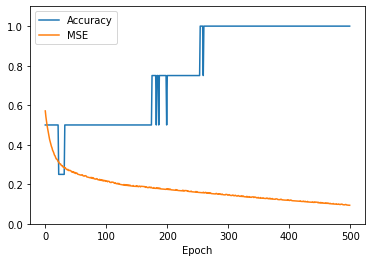

In [16]:
plt.plot(history1.history['accuracy'], label='Accuracy')
plt.plot(history1.history['mse'], label='MSE')
plt.ylim([0, 1.1])
plt.legend()
plt.xlabel('Epoch');

Let's also look at the decision surface of this network:

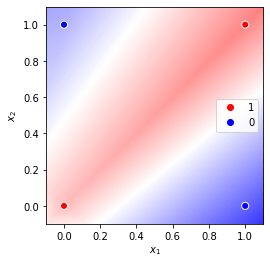

In [17]:
plot_XOR_network(network1)

We can also add more layers and have more nodes in each layer:

In [18]:
network2 = tf.keras.Sequential()
network2.add(tf.keras.layers.Dense(50, activation='relu'))
network2.add(tf.keras.layers.Dense(25, activation='relu'))
network2.add(tf.keras.layers.Dense(12, activation='relu'))
network2.add(tf.keras.layers.Dense(1))

loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.SGD(learning_rate=0.005)
network2.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy', 'mse'])

history2 = network2.fit(X_xor, y_xor, batch_size=2, epochs=500, verbose=0)

In [19]:
network2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (2, 50)                   150       
                                                                 
 dense_3 (Dense)             (2, 25)                   1275      
                                                                 
 dense_4 (Dense)             (2, 12)                   312       
                                                                 
 dense_5 (Dense)             (2, 1)                    13        
                                                                 
Total params: 1,750
Trainable params: 1,750
Non-trainable params: 0
_________________________________________________________________


This model has far more complexity than is necessary for this problem - a total of 1,750 parameters is orders of magnitude larger than necessary, but it still finds a good solution.

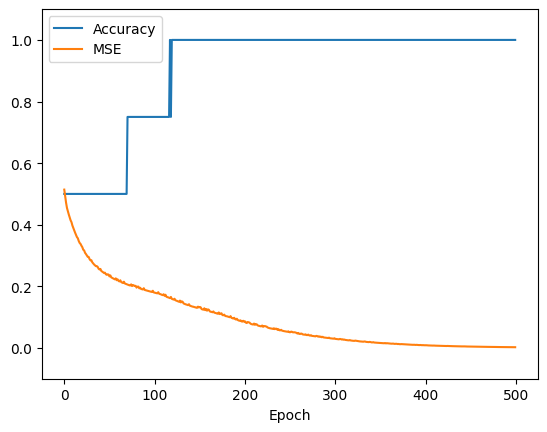

In [20]:
plt.plot(history2.history['accuracy'], label='Accuracy')
plt.plot(history2.history['mse'], label='MSE')
plt.ylim([-0.1, 1.1])
plt.legend()
plt.xlabel('Epoch');

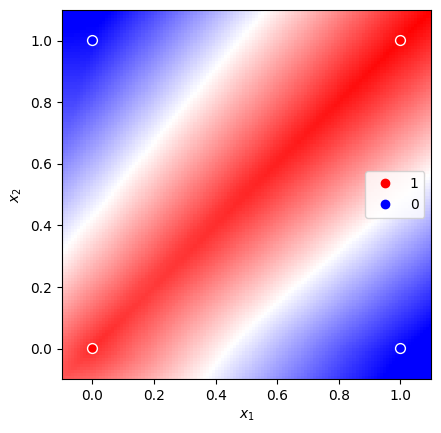

In [21]:
plot_XOR_network(network2)

## Loss Functions and Softmax

The squared error loss probably isn't the best loss function to be using: it is designed for regression problems. Instead, we can use the cross entropy loss.  To do this, one thing we need to do is change our expected outputs from being 0 or 1 to be "one-hot-encoded:"

In [22]:
y_xor_one_hot = tf.keras.utils.to_categorical(y_xor, 2)
print(y_xor_one_hot)

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In one-hot-encoding, each output is now a vector with zero at each class label that is not correct for the associated input and one at the class label that is correct.  One thing to note with this modification is that our network will now have two outputs.

It's also useful to restrict the outputs of our network to look like probabilities.  One way to do this would be to normalize the outputs to be
\begin{align*}
z_1' &= \frac{z_1}{z_1 + z_2} \\
z_2' &= \frac{z_2}{z_1 + z_2}
\end{align*}
which gives us $z_1'$ and $z_2'$ values each between zero and one and summing to one.  One thing to keep in mind here is that although these now form a probability distribution, it isn't necessarily accurate to view $z_1'$ as the "probability that the input is of class one" because the approximation given by our network may not be a perfect statstical model of that fact.

Another way to do this would be to take the hard max of the outputs,
\begin{align*}
z_1' &= \begin{cases} 1 & z_1 \geq z_2 \\ 0 & z_1 < z_2 \end{cases} \\
z_2' &= \begin{cases} 0 & z_1 \geq z_2 \\ 1 & z_1 < z_2 \end{cases},
\end{align*}
which has similar nice properties but is unfortunately not differentiable, so we can't actually use it for classification.

A comprimise between these two is softmax.  For our two raw outputs, $z_1$ and $z_2$, the softmax activation function is calculated as
\begin{align*}
\text{softmax}(z_1) &= \frac{e^{z_1}}{e^{z_1} + e^{z_2}} \\
\text{softmax}(z_2) &= \frac{e^{z_2}}{e^{z_1} + e^{z_2}}
\end{align*}
This is very similar to normalization, but with the exponential function of the raw inputs instead.  This means that values will be driven to behave more similarly to the hardmax while still maintaining differentiability

### Visualizing the effect of the softmax function

Here is a simple bit of code to help you visualize what happens when the activations on the last layer of a classification network are run through the softmax function:

In [23]:
def apply_softmax(acts) :
    exp_acts = np.array([np.exp(x) for x in acts])
    exp_acts_sum = np.sum(exp_acts)
    acts_smax = np.array([np.exp(x)/exp_acts_sum for x in acts])
    return exp_acts, acts_smax

def visualize_softmax(mean, sigma, nsamples, rseed) :
    rng = np.random.default_rng(rseed)
    act = rng.normal(mean, sigma, nsamples)
    aex, asf = apply_softmax(act)
    plt.style.use('seaborn-deep')
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(13,5))
    ax1.bar(range(nsamples), act, color='darkred')
    ax1.set_xlabel('Output Node')
    ax1.set_ylabel('Activation')
    ax1.set_title('Input Activations')   
    ax2.bar(range(nsamples), aex, color='darkblue')
    ax2.set_xlabel('Output Node')
    ax2.set_ylabel('After Exponentiation')
    ax2.set_title('Exponentiated Input Activation')  
    ax3.bar(range(nsamples), asf, color='darkgreen')
    ax3.set_xlabel('Output Node')
    ax3.set_ylabel('Activation')
    ax3.set_title('Softmax applied to Activations')
    

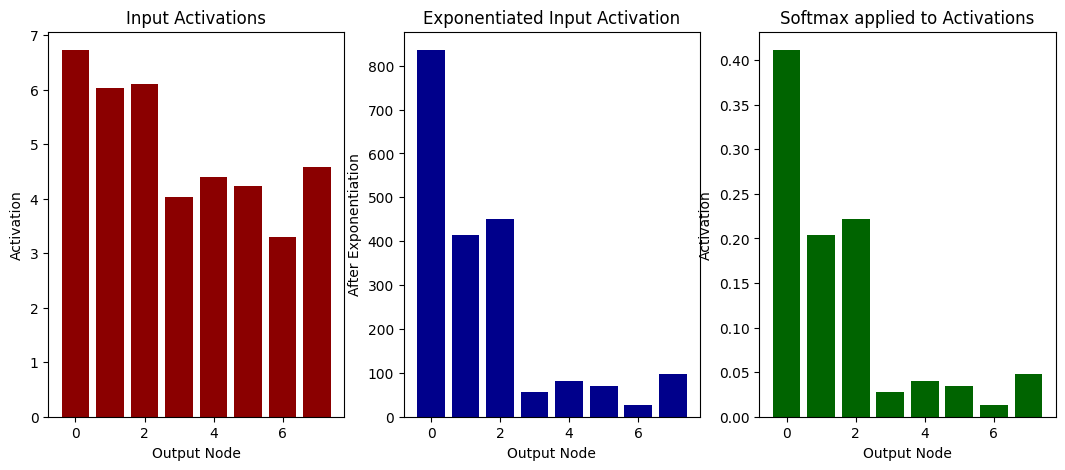

In [24]:
visualize_softmax(5, 1.0, 8, 82)

In the network below we use the ```BinaryCrossentropy``` loss function  which is cross entropy for two classes with a softmax activation on our output layer.

In [26]:
network3 = tf.keras.Sequential()
network3.add(tf.keras.layers.Dense(10, activation='relu'))
network3.add(tf.keras.layers.Dense(2, activation='softmax'))

loss_fn = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
network3.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy', 'mse'])

In [27]:
history3 = network3.fit(X_xor, y_xor_one_hot, batch_size=2, epochs=600, verbose=0)

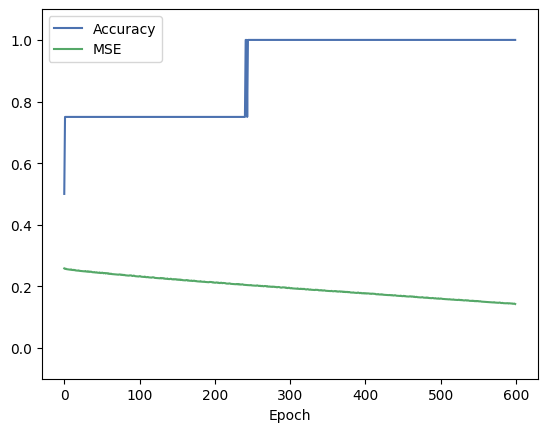

In [28]:
plt.plot(history3.history['accuracy'], label='Accuracy')
plt.plot(history3.history['mse'], label='MSE')
plt.ylim([-0.1, 1.1])
plt.legend()
plt.xlabel('Epoch');

To visualize the decision surface, we will plot $z_1 - z_2$.  This is a trick we will use throughout the rest of the notebook.

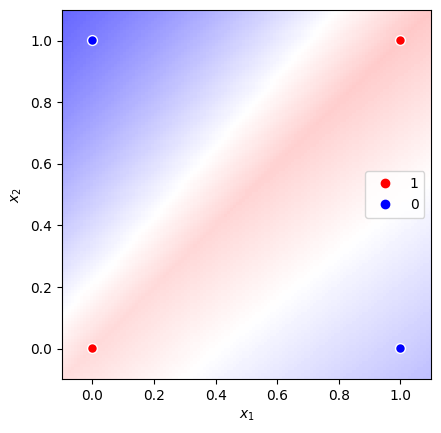

In [29]:
plot_XOR_network(network3, two_outputs=True)

## Nonconvex Optimization

For linear models, finding a solution that minimizes some quantity of interest was relatively easy because the error surface has a single global minimum.  Whenever the error function satisfies a certain condition known as "convexity", this is guaranteed to be the case.
Here's an example of a loss surface of a convex problem:

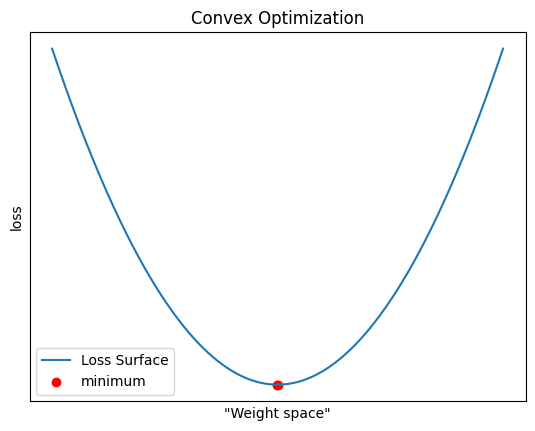

In [30]:
x = np.linspace(-10, 10, 1000)
y = np.power(x, 2)
points = np.r_[True, y[1:] <= y[:-1]] & np.r_[y[:-1] <= y[1:], True]
plt.plot(x, y, label='Loss Surface')
plt.xlabel('"Weight space"')
plt.ylabel('loss')
plt.title("Convex Optimization")
plt.xticks([])
plt.yticks([])
plt.scatter(x[points], y[points], c='r', label='minimum')
plt.legend();

As we change the weights of the model, we move around on the blue curve.  The goal is to find a configuration of weights that places us at the location of the red dot, which is the minimum of this function.

However, due to the nonlinearity of neural networks, there may be more than one minimum.  For example:

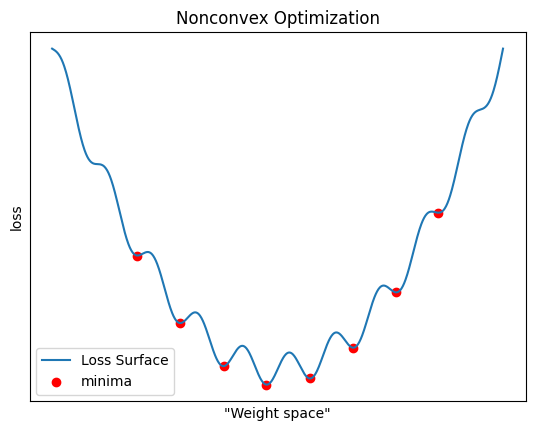

In [31]:
x = np.linspace(-10, 10, 1000)
y = np.power(x, 2) + 5*np.sin(np.pi*x)
points = np.r_[True, y[1:] < y[:-1]] & np.r_[y[:-1] < y[1:], True]
plt.plot(x, y, label="Loss Surface")
plt.xlabel('"Weight space"')
plt.ylabel('loss')
plt.xticks([])
plt.yticks([])
plt.title("Nonconvex Optimization")
plt.scatter(x[points], y[points], c='r', label='minima')
plt.legend();

In this case, there is a single global minimum that represents the optimal solution, but there are a number of other *local* minima.

Gradient descent and many of its variants are the most commonly used algorithms for optimizing the weights of neural networks.  Gradient descent can be thought of as behaving like a ball that is placed on the the loss surface - it rolls down hills.  That means that if an initial configuration of a neural network lies somewhere in a valley around one of the local minima, gradient descent will push it towards that local minimum rather than the global minimum.
However, that may or may not be a problem!  We are interested in solutions that have high prediction accuracy - not necessarily finding the global minimum.


## Gradient Descent Modifications and Regularization

The simple SGD algorithm has a modification that can help with shallow local minima and plateaus in the loss surface - momentum.  Intuitively, this is the same as the idea would be in physics, where the model builds momentum as it travels, and can continue to follow that momentum rather than just going in the direction of most change.  This helps avoid shallow local minima and can prevent the model from slowing down too much on plateaus.

In [32]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

We can also add weight decay to our model, where weights are driven towards small values to reduce the likelihood of overfitting and smooth the loss surface:

In [33]:
reg = tf.keras.regularizers.l2(1e-4)
network4 = tf.keras.Sequential()
network4.add(tf.keras.layers.Dense(10, activation='relu', kernel_regularizer=reg, bias_regularizer=reg))
network4.add(tf.keras.layers.Dense(2, activation='softmax', kernel_regularizer=reg, bias_regularizer=reg))

The rest of our setup is the same as it has been previously.

In [34]:
loss_fn = tf.keras.losses.BinaryCrossentropy()

network4.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy', 'mse'])

In [35]:
history4 = network4.fit(X_xor, y_xor_one_hot, batch_size=2, epochs=100, verbose=0)

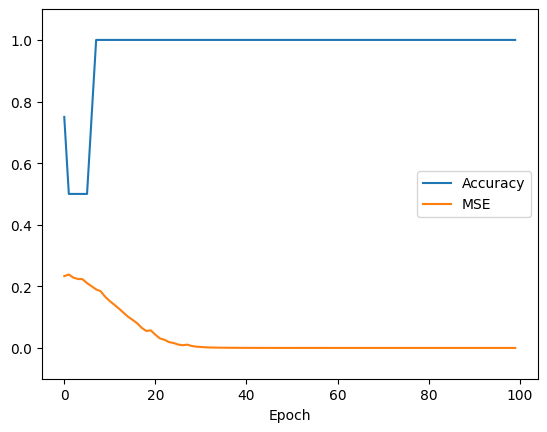

In [36]:
plt.plot(history4.history['accuracy'], label='Accuracy')
plt.plot(history4.history['mse'], label='MSE')
plt.ylim([-0.1, 1.1])
plt.legend()
plt.xlabel('Epoch');

This network trains *much* faster than the previous models.  While testing this notebook, the model frequently achieved zero loss by epoch 50.

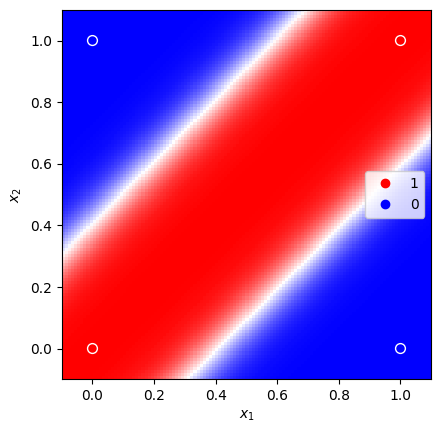

In [37]:
plot_XOR_network(network4, two_outputs=True)

There are also more complex optimizers, such as the [Adam optimizer](https://arxiv.org/pdf/1412.6980.pdf) designed by Diederik Kingma and Jimmy Ba.  It uses a variety of techniques like adaptive learning rates and momentums to provide competitive performance.  To use it in Keras, call it as

In [38]:
opt = tf.keras.optimizers.Adam()

It has default parameters that empirically work well on a wide class of problems.

## Complex Problems

[Neural Networks, Manifolds, and Topology](https://colah.github.io/posts/2014-03-NN-Manifolds-Topology/) by Christopher Olah has animated versions for $\tanh$ networks of some of the investigations and examples shown here.

Now let's consider a slightly more difficult problem for neural networks:

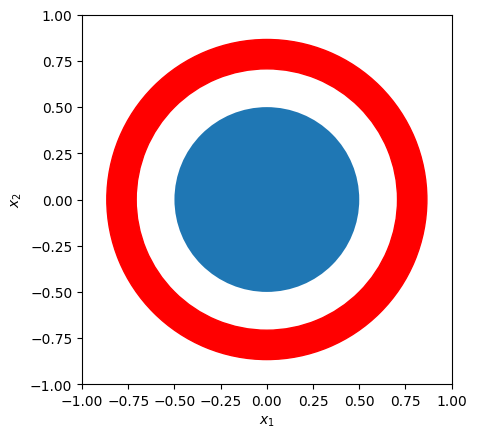

In [39]:
r1 = 0.5
r2 = np.sqrt(2*r1**2)
r3 = np.sqrt(r1**2 + r2**2)

fig = plt.figure()
ax = fig.add_subplot(111)

circle = plt.Circle((0, 0), r1)
annulus = matplotlib.patches.Wedge((0, 0), r3, 0, 360, width=r3-r2, color='r')
ax.add_artist(circle)
ax.add_artist(annulus)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_aspect('equal', 'box');

By itself this is a relatively easy problem - if we convert to polar coordinates, we can just threshold based on the radius and have a very simple classifier that achieves 100% accuracy.  However, if we use the raw $x_1$ and $x_2$ inputs to a neural network, that information must be learned by the network.  The network must be able to construct a closed region in the plane, which requires more complexity than was necessary for XOR.

For training a network we need specific inputs, so we will get 500 points from the circle and 500 from the annulus with their associated class labels:

In [41]:
X_circle = []
y_circle = []
for i in range(500):
    # Circle
    vec = np.random.uniform(-1, 1, 2)
    while np.linalg.norm(vec) > r1:
        vec = np.random.uniform(-1, 1, 2)
    X_circle.append(vec)
    y_circle.append(0)
        
    # Annulus
    vec = np.random.uniform(-1, 1, 2)
    while np.linalg.norm(vec) < r2 or np.linalg.norm(vec) > r3:
        vec = np.random.uniform(-1, 1, 2)
    X_circle.append(vec)
    y_circle.append(1)
    
X_circle = np.array(X_circle)
X_circle = X_circle.astype('float32')
y_circle = np.array(y_circle)
y_circle_one_hot = tf.keras.utils.to_categorical(y_circle, 2)

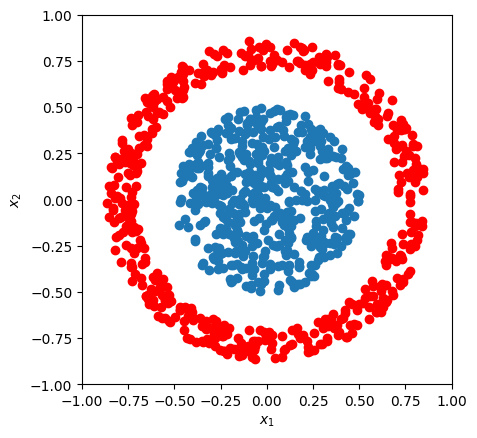

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_circle[y_circle==0, 0], X_circle[y_circle==0, 1])
ax.scatter(X_circle[y_circle==1, 0], X_circle[y_circle==1, 1], c='r')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_aspect('equal', 'box');

Let's train a simple network on this and keep trying until we make sure we get a better solution than random:

In [44]:
accuracy_threshold = 0.79
hidden_width = 2
while True:
    network5 = tf.keras.Sequential()
    network5.add(tf.keras.layers.Dense(hidden_width, activation='relu'))
    network5.add(tf.keras.layers.Dense(2, activation='softmax'))

    loss_fn = tf.keras.losses.BinaryCrossentropy()
    opt = tf.keras.optimizers.Adam()
    network5.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy', 'mse'])
    
    history5 = network5.fit(X_circle, y_circle_one_hot, batch_size=100, epochs=500, verbose=0)
    print('Trained one network to {} accuracy'.format(history5.history['accuracy'][-1]))
    if history5.history['accuracy'][-1] > accuracy_threshold :
        break

Trained one network to 0.7720000147819519 accuracy
Trained one network to 0.800000011920929 accuracy


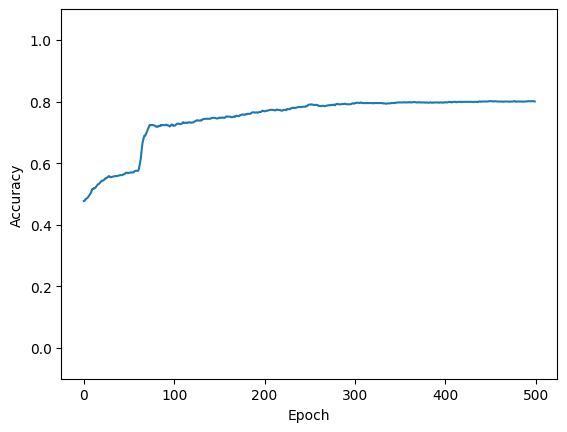

In [45]:
plt.plot(history5.history['accuracy'])
plt.ylim([-0.1, 1.1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

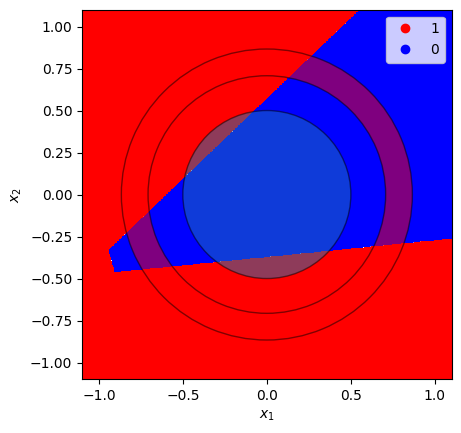

In [46]:
plot_circles_network(network5, two_outputs=True)

Using this architecture it is possible to get accuracy of around 0.8 (and your network will likely look a little bit different from the one plotted above).

Now let's train a network that solves this, with three nodes in its hidden layer.  We may have to train it multiple times for it to find a solution with 100% accuracy.

In [47]:
hidden_width = 3
accuracy_threshold = 0.996
while True:
    network6 = tf.keras.Sequential()
    network6.add(tf.keras.layers.Dense(hidden_width, activation='relu'))
    network6.add(tf.keras.layers.Dense(2, activation='softmax'))

    loss_fn = tf.keras.losses.BinaryCrossentropy()
    opt = tf.keras.optimizers.Adam()
    network6.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy', 'mse'])
    history6 = network6.fit(X_circle, y_circle_one_hot, batch_size=100, epochs=500, verbose=0)
    
    print('Trained one network to {} accuracy'.format(history6.history['accuracy'][-1]))
    if history6.history['accuracy'][-1] >= accuracy_threshold:
        break

Trained one network to 0.7910000085830688 accuracy
Trained one network to 0.9819999933242798 accuracy
Trained one network to 0.9819999933242798 accuracy
Trained one network to 0.9850000143051147 accuracy
Trained one network to 0.7770000100135803 accuracy
Trained one network to 0.9980000257492065 accuracy


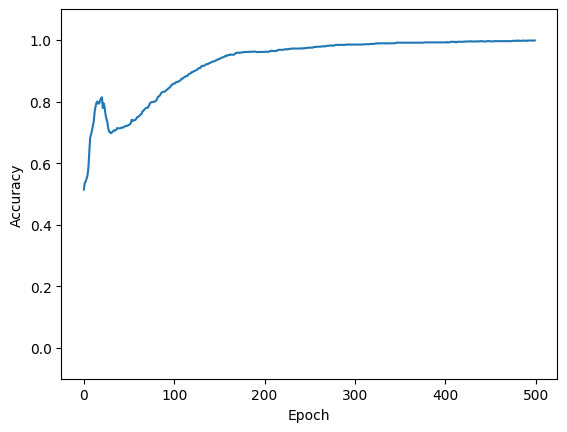

In [48]:
plt.plot(history6.history['accuracy'])
plt.ylim([-0.1, 1.1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

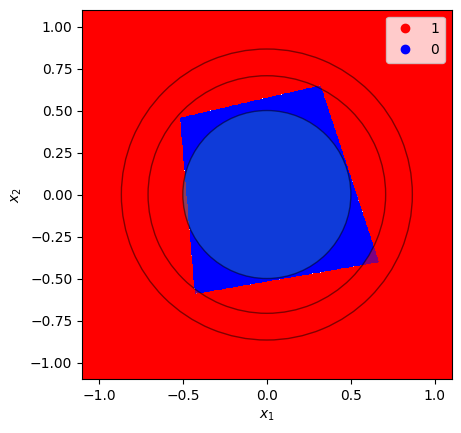

In [49]:
plot_circles_network(network6, two_outputs=True)

### Large Network

We can also train a wider and deeper network on this problem to get a good solution nearly everytime.

In [50]:
network7 = tf.keras.Sequential()
network7.add(tf.keras.layers.Dense(8, activation='relu'))
network7.add(tf.keras.layers.Dense(8, activation='relu'))
network7.add(tf.keras.layers.Dense(8, activation='relu'))
network7.add(tf.keras.layers.Dense(2, activation='softmax'))

loss_fn = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam()
network7.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy', 'mse'])
history7 = network7.fit(X_circle, y_circle_one_hot, batch_size=100, epochs=200, verbose=0)

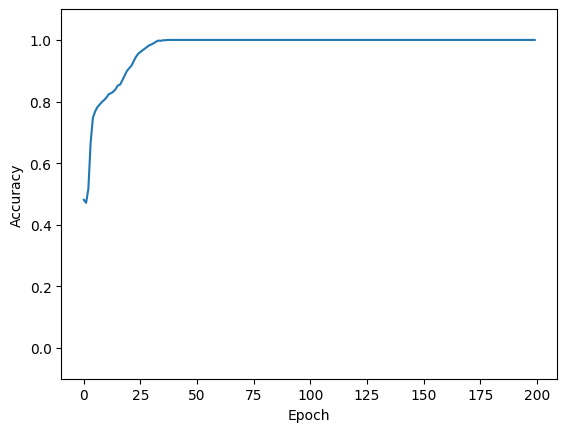

In [51]:
plt.plot(history7.history['accuracy'])
plt.ylim([-0.1, 1.1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

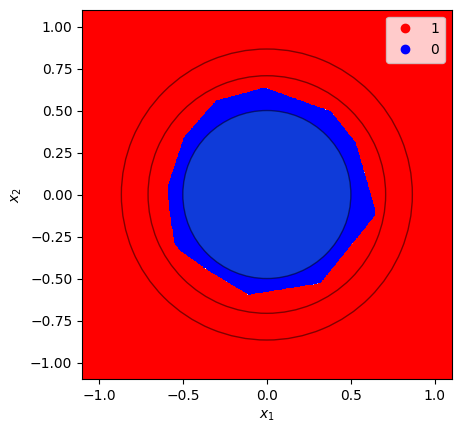

In [52]:
plot_circles_network(network7, two_outputs=True)

## Comments

1. Some of the intuition from these small, two-input networks may not carry over in expected ways to higher dimensional problems.  Unfortunately, building intuition for those more complex problems is typically difficult due to the limited ability to analyze high dimensional networks.  We will discuss more complex problems in our next notebook.
2. Until relatively recently, one of the best methods for hyperparameter selection with neural networks was random search.  More sophisticated methods exist now, but without insight into the dataset it can be difficult to determine how to structure network architecture and training process
3. Keras used to be independent from the chosen backend, but its creator now works for Google (the makers of TensorFlow), and backends like PyTorch are no longer being updated, so the "recommended" backend is TensorFlow.  Keras is also being more closely tied into TensorFlow.